In [58]:
using PyPlot
using JuMP, Ipopt

In [59]:
include("../src/model.jl");
include("../src/diagnostics.jl");
include("../src/optimization.jl");
include("../src/plotting.jl");
include("../src/defaults.jl");

rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams");

### Replicating Belaia configuration

In [60]:
ensemble = Dict()

Dict{Any,Any} with 0 entries

In [66]:
dt = 1. # year timestep
t = Array(2020:dt:2250);

β = 0.02/(3.0)^2 # damages (trillion USD / year / celsius^2)
utility_discount_rate = 0.015 # ρ

# Control technology cost scales, as fraction of GWP (cost scale is for full deployment, α=1.)
mitigate_cost = 200. * 65.e9 / 1.e12 # Costs from Figure 1 https://arxiv.org/abs/1903.02043
geoeng_cost = β * (8.0^2);

# Based on baseline emissions in Figure 4 https://arxiv.org/abs/1903.02043
baseline_emissions_scenario = (
    GtCO2_to_ppm(80.) .- GtCO2_to_ppm(30.) * ( (t .- 2125.) ./ 125.).^2
)

economics = Economics(
    GWP(t), β, utility_discount_rate,
    mitigate_cost, 0., geoeng_cost, 0.,
    0.03, 0., 0., nothing, # Assumed initial condition of zero control deployments in 2020
    baseline_emissions_scenario
);

# Arbitrary initial guess of climate control policies, to be optimized later!
controls = init_zero_controls(t);

physics = Physics()
physics.r = 0.5

mname = "Belaia"
# Create instance of idealized integrated assessment climate model
model = ClimateModel(mname, t, dt, 2020., economics, physics, deepcopy(controls),);

start_deployment=Dict("remove"=>2020., "mitigate"=>2020., "geoeng"=>2020., "adapt"=>2020.)
cost_exponent = Dict("mitigate" => 2.8, "geoeng" => 2., "adapt" => 0., "remove" => 0.)
maxslope = 1. /75.

0.013333333333333334

In [67]:
optimize_controls!(
    model,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>0., "mitigate"=>1., "geoeng"=>0., "adapt"=>0.),
    start_deployment=start_deployment,
    maxslope = maxslope,
    cost_exponent=cost_exponent
);

ensemble["M"] = model;

Solve_Succeeded


### Plotting the optimal solution state

In [68]:
model = ClimateModel(mname, t, dt, present_year, economics, physics, deepcopy(controls),);
optimize_controls!(
    model,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>0., "mitigate"=>2., "geoeng"=>0., "adapt"=>0.),
    start_deployment=start_deployment,
    maxslope = maxslope,
    cost_exponent=cost_exponent
);
ensemble["MR"] = model;

model = ClimateModel(mname, t, dt, present_year, economics, physics, deepcopy(controls),);
optimize_controls!(
    model,
    obj_option = "net_benefit",
    max_deployment=Dict("remove"=>0., "mitigate"=>2., "geoeng"=>1., "adapt"=>0.),
    start_deployment=start_deployment,
    maxslope = maxslope,
    cost_exponent=cost_exponent
);
ensemble["MRG"] = model;

Solve_Succeeded
Solve_Succeeded


#### Replicate Figure 4

In [69]:
ensemble

Dict{Any,Any} with 3 entries:
  "MRG" => ClimateModel("Belaia", [2020.0, 2021.0, 2022.0, 2023.0, 2024.0, 2025…
  "MR"  => ClimateModel("Belaia", [2020.0, 2021.0, 2022.0, 2023.0, 2024.0, 2025…
  "M"   => ClimateModel("Belaia", [2020.0, 2021.0, 2022.0, 2023.0, 2024.0, 2025…

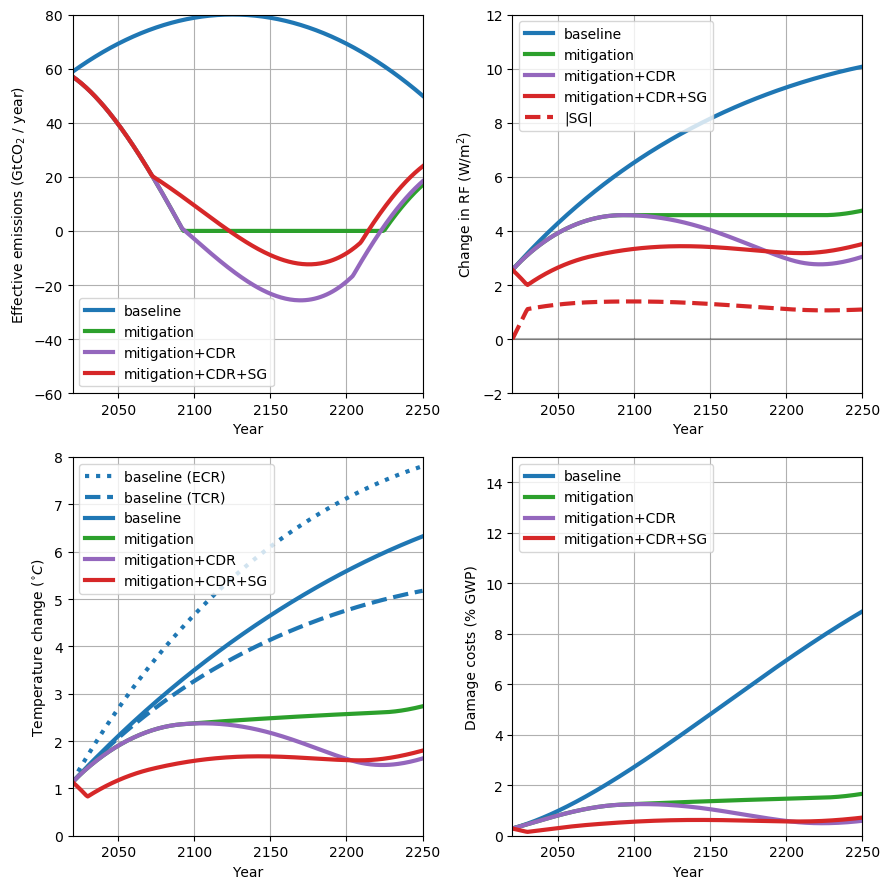

In [70]:
rcParams["lines.linestyle"] = "-"

figure(figsize=(9,9))
subplot(2,2,1)
plot(model.domain, ppm_to_GtCO2(model.economics.baseline_emissions), "C0", label="baseline")
plot(model.domain, ppm_to_GtCO2(controlled_emissions(ensemble["M"])), "C2", label="mitigation")
plot(model.domain, ppm_to_GtCO2(controlled_emissions(ensemble["MR"])), "C4", label="mitigation+CDR")
plot(model.domain, ppm_to_GtCO2(controlled_emissions(ensemble["MRG"])), "C3", label="mitigation+CDR+SG")
legend(loc = "lower left")
ylim([-60,80])
xlim([2020., 2250.])
xlabel("Year")
ylabel(L"Effective emissions (GtCO$_{2}$ / year)")
grid(true)

subplot(2,2,2)
F0 = 2.5
plot(model.domain, 0. * model.domain, "k-", alpha=0.3, lw=1.5)
plot(model.domain, FCO₂_baseline(model)/sec_per_year .+ F0, "C0", label="baseline")
plot(model.domain, FCO₂(ensemble["M"])/sec_per_year .+ F0, "C2", label="mitigation")
plot(model.domain, FCO₂(ensemble["MR"])/sec_per_year .+ F0, "C4", label="mitigation+CDR")
plot(model.domain, FCO₂(ensemble["MRG"])/sec_per_year .+ F0, "C3", label="mitigation+CDR+SG")
plot(model.domain, abs.(FCO₂(ensemble["MRG"]) - FCO₂_no_geoeng(ensemble["MRG"]))/sec_per_year, "C3--", label="|SG|")
xlim([2020., 2250.])
ylim([-2,12])
xlabel("Year")
ylabel(L"Change in RF (W/m$^{2}$)")
legend()
grid(true)

subplot(2,2,3)
plot(model.domain, FCO₂_baseline(model)/(model.physics.B) .+ δT_init, "C0:", label="baseline (ECR)")
plot(model.domain, FCO₂_baseline(model)/(model.physics.B + model.physics.κ) .+ δT_init, "C0--", label="baseline (TCR)")
plot(model.domain, δT_baseline(ensemble["M"]), "C0", label="baseline")
plot(model.domain, δT(ensemble["M"]), "C2", label="mitigation")
plot(model.domain, δT(ensemble["MR"]), "C4", label="mitigation+CDR")
plot(model.domain, δT(ensemble["MRG"]), "C3", label="mitigation+CDR+SG")
xlabel("Year")
ylabel(L"Temperature change ($^{\circ}C$)")
ylim([0,8])
xlim([2020., 2250.])
legend()
grid(true)

subplot(2,2,4)
plot(model.domain, damage_cost_baseline(ensemble["M"])./GWP(t)*100., "C0", label="baseline")
plot(model.domain, damage_cost(ensemble["M"])./GWP(t)*100., "C2", label="mitigation")
plot(model.domain, damage_cost(ensemble["MR"])./GWP(t)*100., "C4", label="mitigation+CDR")
plot(model.domain, damage_cost(ensemble["MRG"])./GWP(t)*100., "C3", label="mitigation+CDR+SG")
xlabel("Year")
ylabel("Damage costs (% GWP)")
xlim([2020., 2250.])
ylim([0., 15.])
grid(true)
legend(loc="upper left")
tight_layout()

savefig("../figures/replicate_Belaia.png", dpi=150, bbox_inches="tight")